Dataset: Kaggle Alzeihmer Dataset, which includes 2 subfolders train and test


Runtime type:
1. T4 GPU: Part 1,2,3
2. TPU v2-8: Part 4



Below are model/variables being saved in ModelCheckpoint folder

Part 1:
1. model_1

Part 2:
2. Zcode_training
3. Zcode_training_noshuffle

Part 3
4. combined_training_data
5. combined_training_data_labels
6. Zcode_testing
7. combined_training_data_noshuffle
8. combined_training_data_noshuffle_labels

Part 4:
9. classifier

Note:
- model_1 will only save the best model
- the rest of model/variables will be re-newed every time.



In [ ]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')
#below where the file is in gdrive, change with your
data_path =  "/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets"

Mounted at /content/drive


# PART 0 STARTS

In [ ]:
# import packages
import tensorflow as tf
from math import ceil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.manifold import TSNE

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.models import load_model

from imblearn.over_sampling import SMOTE

from IPython.display import display
from PIL import Image

In [ ]:
Original_Train ='/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Kaggle Alzheimers Dataset/train'
Original_Test = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Kaggle Alzheimers Dataset/test'

Augmented_Train = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Combined Dataset/train'
# Augmented_Test = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/Datasets/Combined Dataset/test'

In [ ]:
batch_size = 32
numClasses = 4
img_height, img_width, chan_count = 224,224,3


data = ImageDataGenerator(rescale=1.0 / 255)

training_data = data.flow_from_directory(
    Original_Train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training',
    shuffle=True
)

training_data_noshuffle = data.flow_from_directory(
   Original_Train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='training',
    shuffle=False
)

test_data = data.flow_from_directory(
    Original_Test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    # subset='validation',
    shuffle=False
)


Found 5121 images belonging to 4 classes.
Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
training_data.class_indices

{'MildImpairment': 0,
 'ModerateImpairment': 1,
 'NoImpairment': 2,
 'VeryMildImpairment': 3}

In [ ]:
# Get the class labels from the training data
train_labels = training_data.labels

# Count the occurrences of each class
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Print the results
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} data points")

Class 0: 717 data points
Class 1: 52 data points
Class 2: 2560 data points
Class 3: 1792 data points


Determine majority and minority class

In [ ]:
# Get the class labels from the training data
train_labels = training_data.labels

# Count the occurrences of each class
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Find the majority class (the class with the highest count)
majority_class = [unique_classes[np.argmax(class_counts)]]  # Class with the highest count

# Find the minority classes (all other classes)
minority_class = [cls for cls in unique_classes if cls not in majority_class]

# Print the results
print(f"Majority Class: {majority_class}")
print(f"Minority Classes: {minority_class}")


Majority Class: [2]
Minority Classes: [0, 1, 3]


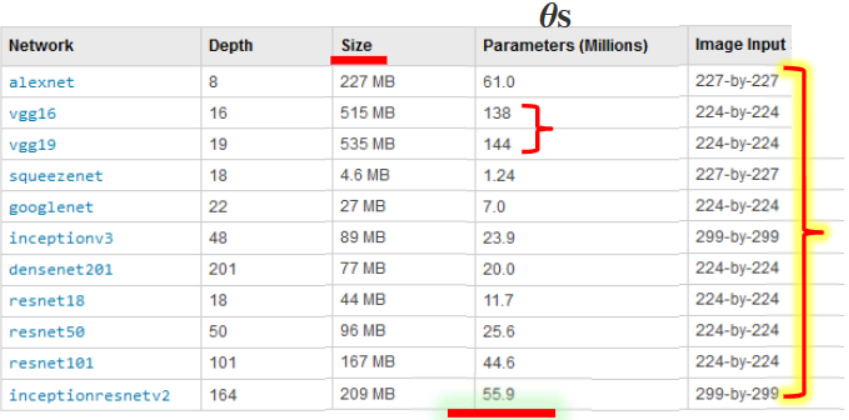

# PART 0 ENDS ____

# RECALL PART 1 ____

base_model/ transfer learning setup

In [ ]:
model_1= load_model('/content/drive/My Drive/AI - Fall 2024/Final Project v.2/ModelCheckpoint/ResNet152V2_model_1.keras')

# PART 2 STARTS ___________

#Smote/Zcode Process:

1. Create model_2, which is used to do Zcode
2. Zcode on
- training_data
- training_data_noshuffle
- testing_data
3. Smote on minority of
- Zcode(training_data)
- Zcode(training_data_noshuffle)
4. Combine/ Concat Zcode( majority) with
- Smote(Zcode(minority of training_data)) ( from step #3)
- Smote(Zcode(minority of training_data_noshuffle)) ( from step #3)
5. Create model_3, which is a new model to test your processed training_data

1. Create model_2 for Zcode of training and testing data

In [ ]:
# Model 2 stops at Flatten() layer
model_2 = Model(inputs=model_1.input, outputs=model_1.get_layer('f1').output)

2. Zcoe on training_data, training_noshuffle, testing_data

2a. Zcode

In [ ]:
# Generate the Z-code features
Zcode_training = model_2.predict(training_data)
Zcode_training_noshuffle = model_2.predict(training_data_noshuffle)
Zcode_testing = model_2.predict(test_data)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1683s 10s/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 910s 23s/step


In [ ]:
# Specify the directory
NB_name= 'ResNet-25Nov'
save_dir = '/content/drive/My Drive/AI - Fall 2024/Final Project v.2/ModelCheckpoint'

# Define unique filenames based on the notebook name
Zcode_training_file = f"{save_dir}/{NB_name}_Zcode_training.npy"
Zcode_training_noshuffle_file = f"{save_dir}/{NB_name}_Zcode_training_noshuffle.npy"
Zcode_testing_file = f"{save_dir}/{NB_name}_Zcode_testing.npy"

# Save the arrays
np.save(Zcode_training_file, Zcode_training)
np.save(Zcode_training_noshuffle_file, Zcode_training_noshuffle)
np.save(Zcode_testing_file, Zcode_testing)



In [ ]:
# Print or check the shape of the minority Z-code array
print("Training Z-code shape:", Zcode_training.shape)
print("Training No-Shuffle Z-code shape:", Zcode_training_noshuffle.shape)
print("Testing Z-code shape:", Zcode_testing.shape)


Training Z-code shape: (5121, 100352)
Training No-Shuffle Z-code shape: (5121, 100352)
Testing Z-code shape: (1279, 100352)


# PART 2 STOPS
# PART 3